<a href="https://colab.research.google.com/github/olkidel/ngs_course/blob/main/Ribo_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.23.0
!pip uninstall -y scipy
!pip install scipy==1.8.1
!pip install statsmodels==0.13.2

Found existing installation: numpy 1.23.0
Uninstalling numpy-1.23.0:
  Successfully uninstalled numpy-1.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.23.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)


Found existing installation: scipy 1.8.1
Uninstalling scipy-1.8.1:
  Successfully uninstalled scipy-1.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/content/01. RiboSeq_RNASeq_HCC_counts.tsv', sep='\t')
df = df.dropna()
# df = df.set_index('geneSymbol')
df.head()

,geneID,geneSymbol,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
0,ENSG00000000003.14,TSPAN6,0,0,402,873,0,0,301,1627,...,218,457,0,0,200,889,0,0,161,857.0
2,ENSG00000000419.12,DPM1,168,239,88,187,114,439,66,201,...,92,170,109,357,60,244,141,173,56,83.0
3,ENSG00000000457.13,SCYL3,65,121,60,106,36,163,70,156,...,127,176,67,176,55,261,64,100,68,176.0
4,ENSG00000000460.16,C1orf112,8,43,18,70,16,76,4,63,...,124,437,7,167,34,201,6,61,9,58.0
5,ENSG00000000938.12,FGR,0,6,19,9,14,13,61,24,...,94,13,3,9,42,26,7,10,26,57.0


разделим на rna и ribo 


In [4]:
ribo = df[[col for col in df.columns if col.endswith("RPF")]]
rna = df[[col for col in df.columns if col.endswith("RNA")]]

**Опеределим корреляцию**

Чисто теоретически конечно можно взять корреляцию Пирсона, но кажется у нас не так много данных ( по хорошему их еще и отнормировать бы ) + мы не уверены что они распределены нормально, так что возьмем Спирмена


In [5]:
from scipy.stats import spearmanr, pearsonr
corr = {ind: spearmanr(ribo.loc[ind].values, rna.loc[ind].values).correlation for ind in rna.index}




/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


g

In [6]:
na_counts = sum(int(np.isnan(val)) for val in list(corr.values()))
correlated_counts = sum(np.abs(val)>0.7 for val in list(corr.values()))
print(f'число генов где не менялась число каунто у рибосек(там были 0 ) {na_counts}, число генов где корееляция > 0.7 по модулю {correlated_counts}')

число генов где не менялась число каунто у рибосек(там были 0 ) 581, число генов где корееляция > 0.7 по модулю 4455


**Посмотрим на распределение корреляции** 
и на то какие гены в топе 

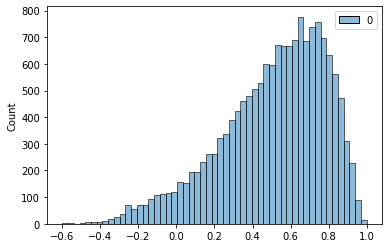

In [7]:
import seaborn as sns
sns.histplot(data=corr.values())




In [8]:
corr_without_na = {id: cor for id, cor in corr.items() if not np.isnan(cor)}
top_percentile = np.percentile(list(corr_without_na.values()), 95)
low_percentile = np.percentile(list(corr_without_na.values()), 1)
top_correlated_genes = [df.loc[id]['geneSymbol'] for id, cor in corr_without_na.items() if cor > top_percentile]
low_correlated_genes = [df.loc[id]['geneSymbol'] for id, cor in corr_without_na.items() if cor > low_percentile]
zero_correlated_genes = [df.loc[id]['geneSymbol'] for id, cor in corr_without_na.items() if cor > -0.005 and cor < 0.005]


In [9]:
top_correlated_genes[:5]

['FUCA2', 'ICA1', 'SLC7A2', 'PRSS22', 'TMEM98']

In [10]:
low_correlated_genes[:5]

['DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH']

In [11]:
zero_correlated_genes[:5]

['PNKP', 'LTK', 'CA11', 'LRCH4', 'UBE2D4']

Не очень уверен, что этом причина, но видно что гены с высокой корреляцией часто расположи на UTR концах , например PRSS22 и TMEM98

А вот со слабой корреляцией некоторые гены на самом деле являются частью кластера генов (и вот кто то имеет рахные варианты альтернативного сплайсинга) как напрмер UBE2D4

Еще низкая корреляция у генов которые отвечают за регуляторные процессы кажется, то есть начинают активироваться при определенных условиях


**Проанализируйте распределение каунтов Ribo-seq**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


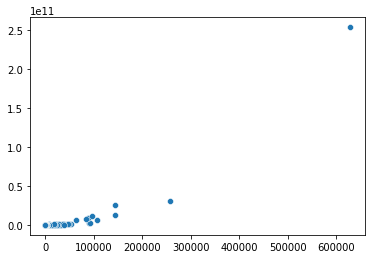

In [12]:
means = ribo.mean(axis=1)
vars = ribo.var(axis=1)
sns.scatterplot(means, vars)

ага, забыл что в логифмической шкале надо смотреть 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


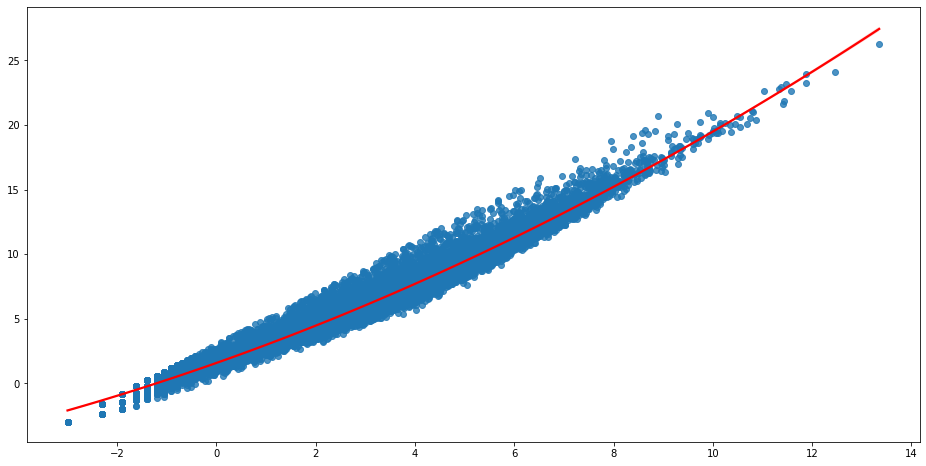

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

sns.regplot(np.log(means[vars!=0]), np.log(vars[vars!=0]), line_kws={'color': 'red'}, order=2)




Дисперсия как будто выше среднего, однако это не гарантирует, что это NB-распредение

ЧТобы проверить можно использовать критерий согласия пирсона(хи-квадрат критерий) (сделать это можно примерно как предлагается вот тут https://stats.stackexchange.com/questions/307814/negative-binomial-distribution и вот тут еще описан тест https://en.wikipedia.org/wiki/Goodness_of_fit)


In [14]:
from scipy.stats import kstest # да это колмогорова-смирнова теста , тоже подойдет для согласия
import tqdm

pvalues = []
for i in tqdm.tqdm(ribo.index):
  
  sample = ribo.loc[i].values
  if np.var(sample) == 0:
    continue
  p = np.mean(sample)/np.var(sample) 
  n = np.mean(sample)*p/(1-p)
  pvalues.append(kstest(ribo.loc[i], 'nbinom', args=(n, p)).pvalue)


100%|██████████| 16257/16257 [00:32<00:00, 494.83it/s] 


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


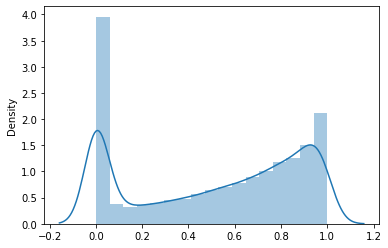

In [15]:
sns.distplot(pvalues) # кажется есть некоторое количство образцов которые бы не прошли тест , но в целом явно если зафиттить всю модель то должно быть ок

In [16]:
!pip install git+https://github.com/owkin/PyDESeq2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/owkin/PyDESeq2 to /tmp/pip-req-build-tbshtfzj
  Running command git clone -q https://github.com/owkin/PyDESeq2 /tmp/pip-req-build-tbshtfzj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


**Начнем искать диффэкспрессированные гены**

In [17]:
import os
import pickle as pkl

from pydeseq2.DeseqDataSet import DeseqDataSet
from pydeseq2.DeseqStats import DeseqStats
from pydeseq2.utils import load_data

In [18]:
AB, samples  = [], []
for col in rna.columns:
    if "normal" in col:
        AB.append("normal")
    else:
        AB.append("tumor")
    samples.append(col)
        
clinical = pd.DataFrame({"sample": samples, "condition": AB})
clinical = clinical.set_index('sample')
clinical.head()

,condition
sample,
LC001-normal-RNA,normal
LC001-tumor-RNA,tumor
LC033-normal-RNA,normal
LC033-tumor-RNA,tumor
LC034-normal-RNA,normal


In [19]:
rna_genes_to_keep = rna.columns[rna.sum(axis=0) >= 10]
rna = rna[rna_genes_to_keep]

In [20]:
rna = rna.T

In [21]:
dds = DeseqDataSet(
    rna,
    clinical=clinical,
    design_factor="condition",
    refit_cooks=True,
)

In [22]:
dds.deseq2()


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 42.98 seconds.

Fitting dispersion trend curve...
... done in 6.24 seconds.

Fitting MAP dispersions...
... done in 38.30 seconds.

Fitting LFCs...
... done in 24.83 seconds.

Refitting 934 outliers.

Fitting dispersions...
... done in 1.66 seconds.

Fitting MAP dispersions...
... done in 1.83 seconds.

Fitting LFCs...
... done in 0.86 seconds.



In [23]:
stat_res = DeseqStats(dds, n_cpus=8)

In [24]:
rna_res = stat_res.summary()

Running Wald tests...
... done in 14.35 seconds.



In [25]:
rna_res = rna_res.join(df[['geneSymbol']]).sort_values('padj').set_index('geneSymbol') # получили результаты дифф экспрессированных генов

In [26]:
rna_res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
geneSymbol,,,,,,
CLEC4G,187.902511,-6.224580,0.473990,-13.132289,2.150569e-39,3.360264e-35
OIT3,207.433311,-4.190142,0.372332,-11.253790,2.218501e-29,1.733204e-25
AVPR1A,216.785200,-4.836002,0.446840,-10.822659,2.688609e-27,1.400317e-23
FCN2,154.170314,-5.701233,0.531761,-10.721419,8.075475e-27,2.523586e-23
INS-IGF2,517.466267,-5.942138,0.554230,-10.721420,8.075370e-27,2.523586e-23


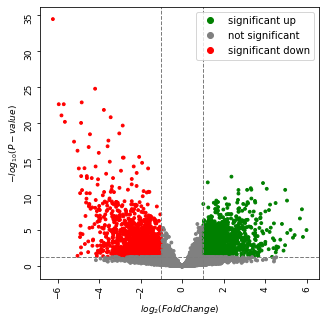

In [27]:
from bioinfokit import visuz

visuz.GeneExpression.volcano(df=rna_res.dropna(), lfc='log2FoldChange', pv='padj', sign_line=True, plotlegend=True, show=True)




In [28]:
ribo_genes_to_keep = ribo.columns[ribo.sum(axis=0) >= 10]
ribo = ribo[ribo_genes_to_keep]

In [32]:

AB, samples  = [], []
for col in ribo.columns:

    if "normal" in col:
        AB.append("normal")
    else:
        AB.append("tumor")
    samples.append(col)
        
clinical = pd.DataFrame({"sample": samples, "condition": AB})
clinical = clinical.set_index('sample')
ribo = ribo.T


In [33]:
dds = DeseqDataSet(
    ribo,
    clinical=clinical,
    design_factor="condition",

)

In [34]:
dds.deseq2()



Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.13 seconds.

Fitting dispersion trend curve...
... done in 5.92 seconds.

Fitting MAP dispersions...
... done in 33.83 seconds.

Fitting LFCs...
... done in 14.55 seconds.

Refitting 698 outliers.

Fitting dispersions...
... done in 1.27 seconds.

Fitting MAP dispersions...
... done in 1.12 seconds.

Fitting LFCs...
... done in 0.76 seconds.



In [35]:
stat_res = DeseqStats(dds, n_cpus=8)
ribo_res = stat_res.summary()
ribo_res = ribo_res.join(df[['geneSymbol']]).sort_values('padj').set_index('geneSymbol') # получили результаты дифф экспрессированных генов
ribo_res.head()

Running Wald tests...
... done in 9.95 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
geneSymbol,,,,,,
CETP,234.786329,-3.661881,0.325381,-11.254132,2.209911e-29,2.924375e-25
OIT3,378.698231,-4.124409,0.385036,-10.711754,8.964694e-27,5.931490e-23
TIMD4,115.869138,-4.411219,0.424640,-10.388129,2.808084e-25,1.238646e-21
ADGRA3,351.339227,-3.789612,0.367740,-10.305147,6.678914e-25,2.209552e-21
CLEC4M,60.046296,-6.019403,0.594080,-10.132304,3.971783e-24,1.051172e-20


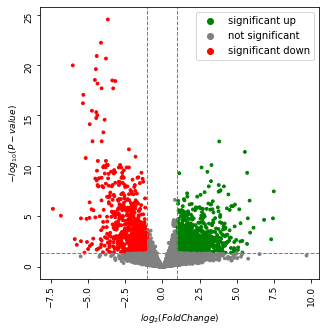

In [36]:
visuz.GeneExpression.volcano(df=ribo_res.dropna(), lfc='log2FoldChange', pv='padj', sign_line=True, plotlegend=True, show=True)

In [41]:
len(set(ribo_res[ribo_res['padj']<0.05].index.values) & set(rna_res[rna_res['padj']<0.05].index.values))/len(set(ribo_res[ribo_res['padj']<0.05].index.values) | set(rna_res[rna_res['padj']<0.05].index.values))


0.28841927303465764

Видно что и графики отличаются и пересечение по генам ~28%

In [47]:
AB, samples, methods  = [], [], []

for col in ribo.T.columns:

    if "normal" in col:
        AB.append("normal")
    else:
        AB.append("tumor")
    samples.append(col)
    methods.append('ribo')

for col in rna.T.columns:

    if "normal" in col:
        AB.append("normal")
    else:
        AB.append("tumor")
    samples.append(col)
    methods.append('rna')
        
clinical = pd.DataFrame({"sample": samples, "condition": AB, 'method':methods})
clinical = clinical.set_index('sample')



In [48]:
whole_ds = pd.concat([ribo, rna])

In [50]:
# dds = DeseqDataSet(
#     whole_ds,
#     clinical=clinical,
#     design_factor="condition + method + method:condition",

# )
# dds.deseq2()



Поддержки двухуровневых моделей еще не завзли ( на гитхабе в доке к функции построения матрицы написано , что они сейчас над этим работают , но по ощущениям там прилично переписать надо 

**Анализ wig-файла**

In [51]:
! wget "https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&save=file&log$=seqview&db=nuccore&report=genbank&id=545778205&conwithfeat=on&hide-sequence=on&hide-cdd=on" -O genome.gb


--2022-12-25 20:46:24--  https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&save=file&log$=seqview&db=nuccore&report=genbank&id=545778205&conwithfeat=on&hide-sequence=on&hide-cdd=on
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘genome.gb’

genome.gb               [      <=>           ]   5.56M   141KB/s    in 41s     

2022-12-25 20:47:07 (139 KB/s) - ‘genome.gb’ saved [5829756]



In [61]:
df_f = pd.read_csv('02. RiboSeq_EColi_track_f.wig', sep='\t')
df_r = pd.read_csv('02. RiboSeq_EColi_track_r.wig', sep='\t')

In [54]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 16.7 MB/s 


In [65]:
from Bio import GenBank

genes_f_pos = {}
genes_r_pos = {}



with open("genome.gb") as handle:
    record = next(GenBank.parse(handle))
    for feature in record.features:
      if feature.key != "CDS":
          continue
      location = feature.location
      if "join" in location:
          continue

      is_back = False
      if location.startswith("complement"):
          location = location[len("complement("):-1]
          is_back = True
      
      for q in feature.qualifiers:
          if q.key == '/gene=':
              gene = q.value[1:-1]
              break
      
      start, end = location.split("..")
      start, end = int(start), int(end)
      
      if is_back:
          genes_r_pos[gene] = start, end
      else:
          genes_f_pos[gene] = start, end

In [63]:
df_f = df_f.reset_index()
df_f.columns = ['start', 'val']

df_r = df_r.reset_index()
df_r.columns = ['start', 'val']


In [67]:
from collections import defaultdict
f_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_f[['start', 'val']].values):
  for gene, (begin, end) in genes_f_pos.items():
    if begin <= start <= end:
      f_gene_coverage[start-begin] += count

r_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_r[['start', 'val']].values):
  for gene, (begin, end) in genes_r_pos.items():
    if begin <= start <= end:
      r_gene_coverage[start-begin] += count
    

100%|██████████| 643345/643345 [06:17<00:00, 1702.36it/s]


In [69]:
f_gene_coverage = pd.DataFrame({
    'offset': [key for key, _ in f_gene_coverage.items()],
    'count': [val for _, val in f_gene_coverage.items()]
})
f_gene_coverage

,offset,count
0,1,35766
1,2,53857
2,3,15873
3,4,17313
4,5,26522
...,...,...
4514,4200,2
4515,4204,12
4516,4206,10
4517,4207,2


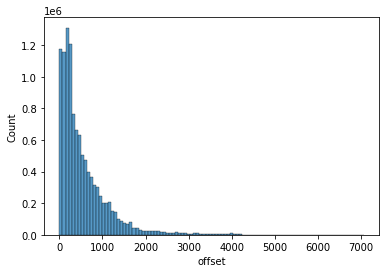

In [72]:
sns.histplot(f_gene_coverage, x='offset', weights='count', bins=100)

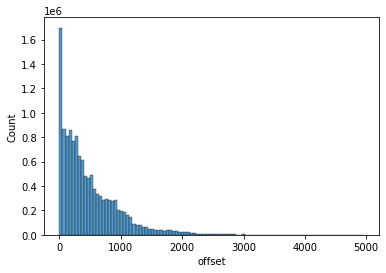

In [75]:
r_gene_coverage = pd.DataFrame({
    'offset': [key for key, _ in r_gene_coverage.items()],
    'count': [val for _, val in r_gene_coverage.items()]
})
sns.histplot(r_gene_coverage, x='offset', weights='count', bins=100)

Видно что в начале ридов больше, это связанно с тем что записаны начала ридом 

Посмотрим на конкретный ген


In [118]:
f_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_f[['start', 'val']].values):
  begin, end = genes_f_pos['mog']
  if begin <= start <= end:
    f_gene_coverage[start-begin] += count


100%|██████████| 621395/621395 [00:01<00:00, 379397.97it/s]


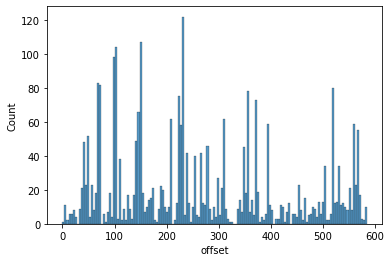

In [119]:
f_gene_coverage = pd.DataFrame({
    'offset': [key for key, _ in f_gene_coverage.items()],
    'count': [val for _, val in f_gene_coverage.items()]
})
sns.histplot(f_gene_coverage, x='offset', weights='count', bins=150)

из неравномерности как будто в первой половине чуть больше ридов и пиков, но все равно не сильно понятна закономерность

In [126]:
import plotly.express as px

f_gene_coverage['color'] = f_gene_coverage.offset % 3
f_gene_coverage['color'] = f_gene_coverage['color'].astype(str)

fig = px.bar(f_gene_coverage, x="offset", y='count', color='color')
fig.show()

Если посмотреть то как будто зеленое идет через 3 и приобладает над остальным

Посчитаем для большого числа генов

In [127]:
from collections import defaultdict
f_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_f[['start', 'val']].values):
  for gene, (begin, end) in genes_f_pos.items():
    if begin <= start <= end:
      f_gene_coverage[start-begin] += count

    

100%|██████████| 621395/621395 [06:07<00:00, 1693.11it/s]


In [130]:
f_gene_coverage = pd.DataFrame({
    'offset': [key for key, _ in f_gene_coverage.items()],
    'count': [val for _, val in f_gene_coverage.items()]
})
f_gene_coverage['color'] = f_gene_coverage.offset % 3
f_gene_coverage['color'] = f_gene_coverage['color'].astype(str)

fig = px.bar(f_gene_coverage, x="offset", y='count', color='color')
fig.show()

непонятно из графика

In [136]:
print(f_gene_coverage.groupby('color')['count'].sum())
print(f_gene_coverage.groupby('color')['count'].mean())

color
0    2702867
1    3462544
2    5190712
Name: count, dtype: int64
color
0    1801.911333
1    2311.444593
2    3412.696910
Name: count, dtype: float64


видно теперь что есть сдвигом на котором сильно больше прочтений

посчитаем RPKM и TPM , отличаются они в нормировке, и кажется что TPM не обладает проблемой того что экспрессия одного гена может потянуть сильно другие гены, так как мы нормируем на общее число

In [137]:
from collections import defaultdict
f_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_f[['start', 'val']].values):
  for gene, (begin, end) in genes_f_pos.items():
    if begin <= start <= end:
      f_gene_coverage[gene] += count

r_gene_coverage = defaultdict(int)
for start, count in  tqdm.tqdm(df_r[['start', 'val']].values):
  for gene, (begin, end) in genes_r_pos.items():
    if begin <= start <= end:
      r_gene_coverage[gene] += count
    

100%|██████████| 643345/643345 [07:09<00:00, 1498.09it/s]


In [152]:
genes_df = {'gene':[],
            'reads': [],
            'length': [],
            'start': [],
            'end': []}
for gene, reads in f_gene_coverage.items():
  genes_df['gene'].append(gene)
  genes_df['reads'].append(reads)
  genes_df['start'].append(genes_f_pos[gene][0])
  genes_df['end'].append(genes_f_pos[gene][1])
  genes_df['length'].append(genes_f_pos[gene][1] - genes_f_pos[gene][0]+1)

for gene, reads in r_gene_coverage.items():
  genes_df['gene'].append(gene)
  genes_df['reads'].append(reads)
  genes_df['start'].append(genes_r_pos[gene][0])
  genes_df['end'].append(genes_r_pos[gene][1])
  genes_df['length'].append(genes_r_pos[gene][1] - genes_r_pos[gene][0]+1)

In [154]:
genes_df = pd.DataFrame(genes_df)

In [155]:
genes_df.head()

,gene,reads,length,start,end
0,thrL,811,66,190,255
1,thrA,34298,2463,337,2799
2,thrB,6705,933,2801,3733
3,thrC,19613,1287,3734,5020
4,yaaX,121,297,5234,5530


In [156]:
genes_df = genes_df.set_index('gene')

In [157]:
genes_df['RPKM'] = genes_df['reads']/((genes_df["length"] / 1000)* (genes_df["reads"].sum() / 1000000))

In [158]:
genes_df['TPM'] = genes_df['reads']/(genes_df["length"] / 1000)
genes_df['TPM'] /= genes_df['TPM'].sum()/1000000

In [159]:
genes_df.head()

,reads,length,start,end,RPKM,TPM
gene,,,,,,
thrL,811,66,190,255,507.488347,304.785070
thrA,34298,2463,337,2799,575.113471,345.399063
thrB,6705,933,2801,3733,296.801639,178.251794
thrC,19613,1287,3734,5020,629.382463,377.991690
yaaX,121,297,5234,5530,16.825891,10.105218


Посмотрим теперь на оперон

In [166]:
atp_operon = ['atpB', 'atpE', 'atpF', 'atpH', 'atpA', 'atpG', 'atpD', 'atpC', 'atpI']

In [167]:
print(f'границы оперона {genes_df.loc[atp_operon].start.min()}:{genes_df.loc[atp_operon].end.max()}')


границы оперона 3915553:3922440


In [168]:
genes_df.loc[atp_operon].sort_values('TPM')

,reads,length,start,end,RPKM,TPM
gene,,,,,,
atpI,511,381,3922060,3922440,55.391749,33.266928
atpG,12615,864,3917402,3918265,603.007437,362.151496
atpH,9440,534,3919870,3920403,730.095872,438.477697
atpF,12632,471,3920418,3920888,1107.644425,665.224109
atpC,11572,420,3915553,3915972,1137.910986,683.401465
atpB,22894,816,3921236,3922051,1158.725796,695.902330
atpA,73132,1542,3918316,3919857,1958.719436,1176.358914
atpD,84129,1383,3915993,3917375,2512.306966,1508.830024
atpE,71394,240,3920950,3921189,12285.692161,7378.485770


почитал что может быть . не очень уверен, но кажется можно предположить что гены atpI, atpG, atpH носят регуляторную функцию для всего оперона и например позволяют меньше экспрессировать в случае наличия в среде большого числа глюкозы. 


Можно ли было бы такое найти с помощью обычного RNA-seq -кажется нет. Но это верно при условии того что мой прошлый вывод оказался верным